## Basic modeling with the TRCRP Mixture

This tutorial notebook shows the basic interface for creating a TRCRP mixture model for four time series, running inference to fit the model, and simulating values for imputation and forecasting.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
rng = np.random.RandomState(1)

### Loading and plotting the time series dataset

In [4]:
frame = pd.read_csv('resources/ggToyMissing.csv', index_col=0)

Each column in `frame` is a time series variable, and `frame.index` contains the integer-valued timepoints at which the time series were observed. Values in the index need not be contiguous, so long as they are integer-valued.

In [5]:
frame.head()

,a,b,c,d
0,-0.179312,-0.292974,2.792519,1.869283
1,-0.414784,-0.391834,1.734128,1.472738
2,-0.483769,-0.436033,0.627319,0.960280
3,-0.459103,-0.573395,0.257649,0.819960
4,-0.489040,-0.521472,-0.019140,-0.239753


This dataset has missing values for variables `a` and `d`, which are encoded as `float(nan)` values. For example, `a` is not observed at time points 100, 101, 102, 103, 104, ....

In [6]:
frame[pd.isnull(frame['a'])].head()

,a,b,c,d
100,NaN,-0.581752,0.019613,-0.781691
101,NaN,-0.564875,0.062787,-0.377687
102,NaN,-0.545189,0.987036,-0.457000
103,NaN,-0.606666,-0.251298,-0.035626
104,NaN,-0.597310,-0.531743,-0.623570


Similarly, `d` is not observed at time points 20, 21, 2, 23, 24.

In [7]:
frame[pd.isnull(frame['d'])].head()

,a,b,c,d
20,-0.993966,-1.107563,-7.369576,NaN
21,-1.026810,-1.070512,-6.538912,NaN
22,-1.069871,-1.040572,-6.875310,NaN
23,-1.049251,-1.100071,-6.345228,NaN
24,-0.999196,-1.040606,-5.762845,NaN


We can also plot the time series.

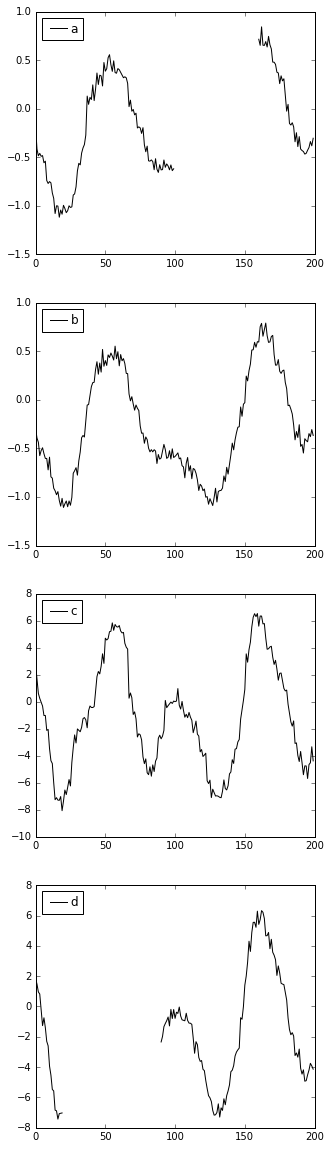

In [8]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, frame.columns):
    index = list(frame.columns).index(variable)
    x_observed = frame.index
    y_observed = frame.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)
fig.set_size_inches(5,20)

### Creating a TRCRP mixture model and incorporating data

We now create a TRCRP mixture model for the time series. The `chains` parameter specifies the number of MCMC chains to use for inference; `lag` is a parameter specifying the window-length for the model (this parameter plays a similar role to that of the order $p$ in an AR(p) model); `variables` is a list of names of the time series; and `rng` is the source of randomness.

In [9]:
from trcrpm import TRCRP_Mixture
model = TRCRP_Mixture(chains=4, lag=10, variables=frame.columns, rng=rng)

We now incorporate the observations into the model. New observations can be continuously incorporated into the model (for illustration, below we first incorporate half the data, and then incorporate the rest of the data).

In [10]:
%%timeit -n1 -r1
model.incorporate(frame)

1 loop, best of 1: 1.92 s per loop


### Running MCMC inference to learn the latent parameters

In [11]:
model.resample_all(seconds=20)

Completed: 114 iterations in 20.007191 seconds.
Completed: 122 iterations in 20.024191 seconds.
Completed: 112 iterations in 20.027967 seconds.
Completed: 71 iterations in 20.029477 seconds.


In [12]:
model.resample_hyperparameters(seconds=10)

Completed: 14 iterations in 10.037809 seconds.
Completed: 14 iterations in 10.131742 seconds.
Completed: 12 iterations in 10.127735 seconds.
Completed: 8 iterations in 10.188054 seconds.


In [13]:
probes = range(300)
numsamples = 20
samples = model.simulate(probes, model.variables, numsamples)

In [14]:
def plot_latent_state_sequence(timesteps, values, states, ax):
    assert len(timesteps) == len(states)
    unique = sorted(set(states))
    colors = matplotlib.cm.Set1(np.linspace(0, 1, len(unique)))
    y_low, y_high = ax.get_ylim()
    y_mid = np.mean([y_low, y_high])
    y_height = 0.05 * (y_high - y_low)
    for state, color in zip(unique, colors):
        xs = timesteps[states==state]
        for x in xs:
            ax.fill_between([x-1, x], [y_mid-y_height]*2, [y_mid+y_height]*2,
                alpha=0.3, color=color)

In [15]:
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = model.dataset.index
    y_observed = model.dataset.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    # Plot 25--75 percentile bands around the simulated data. 
    samples = simulations[:,:,index]
    ax.fill_between(
        probes,
        np.percentile(samples, 25, axis=0),
        np.percentile(samples, 75, axis=0),
        color='gray',
        alpha=0.5)
    ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
    #  Optionally plot latent temporal state at each timepoint,
    #  according to a given chain in the model.
    if states_from_chain is not None:
        assert 0 <= states_from_chain < model.chains
        states = model.get_temporal_regimes(variable)[states_from_chain]
        plot_latent_state_sequence(x_observed, y_observed, states, ax)
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)

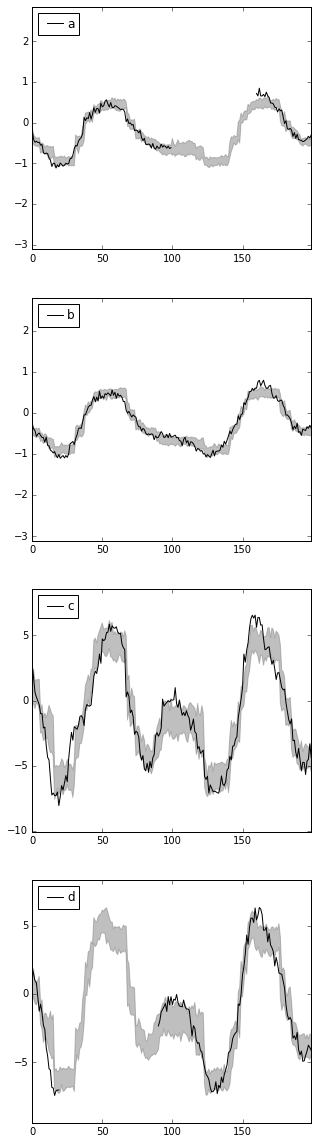

In [16]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(model.dataset.index), max(model.dataset.index)])
fig.set_size_inches(5,20)

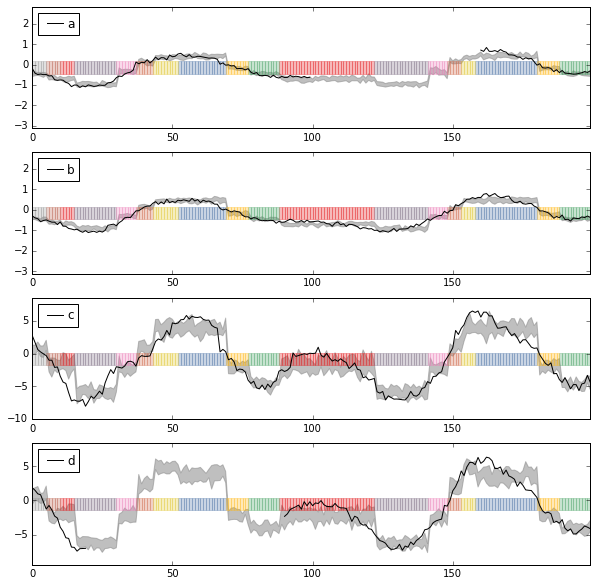

In [17]:
chain = 0
samples_chain = samples[numsamples*chain:numsamples*(chain+1)]

fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples_chain, variable, ax, states_from_chain=chain)
    ax.set_xlim([min(model.dataset.index), max(model.dataset.index)])
fig.set_size_inches(10,10)

### Forecasting

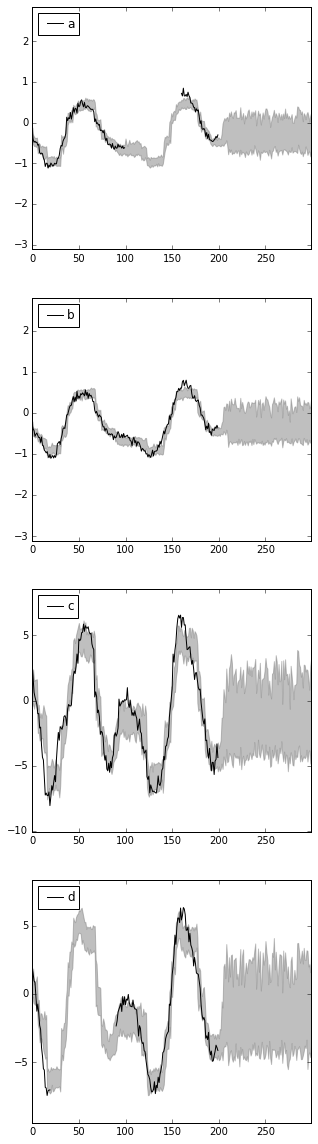

In [18]:
fig, axes = plt.subplots(nrows=4)
for ax, variable in zip(axes, model.variables):
    plot_predictions(samples, variable, ax)
    ax.set_xlim([min(probes), max(probes)])
fig.set_size_inches(5, 20)